In [1]:
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import time
import os
import warnings
import re
import networkx as nx
from tqdm import tqdm
import matplotlib.ticker as tk
from matplotlib.ticker import FormatStrFormatter
          
warnings.filterwarnings('ignore')

# from support_library.plot_support import *
pd.set_option('display.max_columns', None)

%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [155]:
# setting up the styling for the plots in this notebook
sns.set(style="white", 
        palette="colorblind", 
        font_scale=0.95, 
        rc={"figure.figsize":(15,12)})

In [156]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [4]:
folder='csv'

In [157]:
df = pd.read_csv(get_path(folder, 'all_camp_deals_trg_new.csv'), sep=';', encoding='utf8', compression='gzip')
df.columns=df.columns.map(lambda x: x.lower())
df.prod_gr_atb_seg=df.prod_gr_atb_seg.apply(lambda x: x.strip())
df.head(30)

,src_det,tr_id,src_detail,prod_gr_atb_seg,id,ckp_id,info,segment_client,priority_client,company_id,inn,date_create,date_close,status_result,product,amount,tb_vko,gosb_vko,rm_fio,vko_id,fio_vko,task_id,status_task,status_result_task,comment_txt_task,flag_deal,flag_deal_completed,amount_create,amount_complete,type_object,date_load,flag_ckr,date_close_task,executor_id,fio_executor,tb_executor,gosb_executor,osb_executor,vsp_executor,rm_id_executor,rm_fio_executor,flag_equal_product,product_id,flag_deal_holding,c,s
0,T047,47,"NBA,T047,OTR,OTR2",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-R31FJL1,ЦА-ЕДНБАЗММБ-0618,Заключение договора,Микро,Ключевой,1-EOBAWF,732800606272,2018-07-06,NaN,13.Закрыта/Отказ,Зарплатные проекты,50.0,Поволжский банк,Ульяновское ГОСБ №8588,Трегубова Наталья Анатольевна,1-1IPM2-15,Краснов Станислав Владимирович,1-QDL7JGF,Продукт не интересен,Нет потребности в наст.время,"Сказал подумает, ответ даст позже.договорились...",1,0,0.0,0.0,Deal,2018-12-11,0,2018-06-27,1-1IPM2-15,Краснов Станислав Владимирович,Поволжский банк,Ульяновское ГОСБ №8588,-,8588/2,1-69W4-54,Трегубова Наталья Анатольевна,1,1-1GW0,0,1.0,0.0
1,T047,47,"NBA,T047,OTR,OTR2",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-RBAG17E,ЦА-ЕДНБАЗММБ-0618,ЗПК,Микро,Ключевой,1-2GYZFTQ,231707900725,2018-07-11,NaN,12.Закрыта/Заключена,Зарплатные проекты,10.0,Юго-Западный банк,Краснодарское ГОСБ №8619,Сергейчик Александра Сергеевна,1-1L4XQ-53,Григорян Ерануи Лерниковна,1-QDLFY0T,Создана сделка,Истёк срок действия,NaN,1,1,0.0,0.0,Deal,2018-12-11,0,2018-07-12,1-1L4XQ-53,Григорян Ерануи Лерниковна,Юго-Западный банк,Краснодарское ГОСБ №8619,-,8619/14,1-NPN0R5W,Сергейчик Александра Сергеевна,1,1-1GW0,0,1.0,0.0
2,T047,47,"OTR2,NBA,T041,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-SMTD3XU,ЦА-ЕДНБАЗММБЦКР-0718,ЗПП/ЛАЙТКАБ/03250006025,Малые,ЦКР,1-EMEJHG,32500060258,2018-08-23,NaN,12.Закрыта/Заключена,Зарплатные проекты,100.0,Байкальский банк,Бурятское ГОСБ №8601,Сагайдак Юлия Ярославна,1-GCRM-35,Асеева Виктория Евгеньевна,1-R1IC47I,Продукт не интересен,Нет потребности в наст.время,"""""""Нет потребности в настоящее время; """"""",1,1,0.0,0.0,Deal,2018-12-11,1,2018-09-03,1-LS2735M,Баканова Кристина Евгеньевна,Центральный аппарат,Региональный центр Тольятти,NaN,NaN,NaN,NaN,1,1-1GW0,0,1.0,0.0
3,T047,47,"OTR,NBA,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-OMSVVWN,ЦА-ЕДНБАЗММБ-0418,ЗПК,Микро,Ключевой,1-E6O9FV,360500137994,2018-04-11,NaN,04.Формирование предложения,Зарплатные проекты,0.0,Центрально-Черноземный банк,ГО по Воронежской области,Герасимов Алексей Владимирович,1-IW8BNJM,Николашина Витория Алексеевна,1-OJRJY37,Создана сделка,NaN,NaN,1,0,0.0,0.0,Deal,2018-12-11,0,2018-04-11,1-IW8BNJM,Николашина Витория Алексеевна,Центрально-Черноземный банк,ГО по Воронежской области,-,9013/11,1-PO-43,Герасимов Алексей Владимирович,1,1-1GW0,0,1.0,0.0
4,T047,47,"NBA,T020,T041,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-OWFLZDH,ЦА-ЕДНБАЗММБ-0418,зп,Микро,ЦКР,1-DBO0XE5,637701123560,2018-04-23,2018-05-21,12.Закрыта/Заключена,Зарплатные проекты,70.0,Поволжский банк,Самарское ГОСБ №6991,Чекмасова Ольга Александровна,1-1CJ36-33,Мишина Ольга Викторовна,1-OJRK6U1,Создана сделка,Истёк срок действия,"Согласен, первое зачисление в апреле",1,1,0.0,0.0,Deal,2018-12-11,0,2018-04-24,1-1CJ36-33,Мишина Ольга Викторовна,Поволжский банк,Самарское ГОСБ №6991,-,6991/6,1-FLMZ-52,Чекмасова Ольга Александровна,1,1-1GW0,0,1.0,0.0
5,T047,47,"OTR,NBA,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-RJ8A1QP,ЦА-ЕДНБАЗММБЦКР-0518,ЗПП лайткаб,Микро,ЦКР,1-28QPU69,772635536835,2018-07-18,NaN,13.Закрыта/Отказ,Зарплатные проекты,100.0,Московский банк,Московский банк,Карпиза Андрей Петрович,1-3L5Z99X,Березкина Светлана Игоревна,1-PWQW3DX,Продукт не интересен,Не подходит для деят. клиента,ст20,1,0,0.0,0.0,Deal,2018-12-11,1,2018-07-05,1-LFIY5MU,Проскурина Ирина Олеговна,Центральный аппарат,Региональный центр Тольятти,NaN,NaN,NaN,NaN,1,1-1GW0,0,1.0,0.0
6,T047,47,"NBA,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-RWLPOT4,ЦА-ЕДНБАЗММБЦКР-0518,Лайткаб 613703603755 (Сделка закрыта автоматич...,Микро,ЦКР,1-DG8YNL,613703603755,2018-07-31,NaN,12.Закрыта/Заключена,Зарпла

In [159]:
df.loc[( (df.amount_complete>0) | (df.flag_deal_completed>0) ), df.columns.isin(['src_det','tr_id','prod_gr_atb_seg'])]

,src_det,tr_id,prod_gr_atb_seg
1,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
2,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
4,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
6,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
7,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
9,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
11,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
14,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
15,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ
16,T047,47,ЗАРПЛАТНЫЕ ПРОЕКТЫ


In [164]:
df.groupby(['task_id'])['task_id'].count().to_frame().rename(columns={'task_id':'task_id_cnt'}).reset_index()

,task_id,task_id_cnt
0,1-HRJHL1J,1
1,1-HRJHL2K,1
2,1-HRJHL5Y,1
3,1-HRJHL84,1
4,1-HRJIJSG,1
5,1-HRJJ6HR,1
6,1-HRJJ74D,1
7,1-HRJJN16,1
8,1-HRJJN7U,1
9,1-HRJKBWE,1


In [6]:
df.prod_gr_atb_seg.value_counts()

ЗАРПЛАТНЫЕ ПРОЕКТЫ                 33733
КРЕДИТОВАНИЕ                        5753
ЛИЗИНГ                              2748
ЭКВАЙРИНГ                           1817
БИЗНЕС-КАРТА                        1429
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ        1067
БАНКОВСКАЯ ГАРАНТИЯ                  603
СТРАХОВАНИЕ                          485
CASH MANAGEMENT                      200
ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ           199
ИНКАССАЦИЯ                           152
КОНВЕРСИОННЫЕ ОПЕРАЦИИ               113
КОМПЛЕКСНОЕ СТРАХОВАНИЕ БИЗНЕСА       74
ФАКТОРИНГ                             40
РКО                                   27
ВЕКСЕЛЯ                                3
ВАЛЮТНЫЙ КОНТРОЛЬ                      1
Name: prod_gr_atb_seg, dtype: int64

In [118]:
prod_gr_name='ЭКВАЙРИНГ'

In [119]:
len_tot  = len(df), 
len_comp = len(df[( (df.amount_complete>0) | (df.flag_deal_completed>0) )])
len_prod = len(df[(df.prod_gr_atb_seg==prod_gr_name)])

In [120]:
len_tot, len_comp, len_prod

((48444,), 25380, 1817)

In [121]:
# completed deals
len(df[(df.prod_gr_atb_seg==prod_gr_name)]),  len(df[( (df.amount_complete>0) | (df.flag_deal_completed>0) ) & 
                 (df.prod_gr_atb_seg==prod_gr_name)])

(1817, 816)

In [122]:
# total convertation  
totConv=len(df[( (df.amount_complete>0) | (df.flag_deal_completed>0) ) & 
                 (df.prod_gr_atb_seg==prod_gr_name)])/len(df[df.prod_gr_atb_seg==prod_gr_name])*100
totConv

44.90919097413318

In [123]:
bins=1000
windowing_list=[]
thresholding=np.linspace(0,df.s.max(),bins)

for i in tqdm(np.arange(len(thresholding))):
    part_df=df[( (df.amount_complete>0) | (df.flag_deal_completed>0) ) & 
                 (df.prod_gr_atb_seg==prod_gr_name) & 
                 (df.s < thresholding[i] )]
    windowing_list.append((thresholding[i],len(part_df)/len_prod*100))

100%|██████████████████████████████████████| 1000/1000 [00:12<00:00, 81.88it/s]


In [124]:
convert_df=pd.DataFrame(data=windowing_list,columns=['thresholding','convertation'])

In [125]:
convert_df.head(10)

,thresholding,convertation
0,0.000000e+00,0.000000
1,4.666108e+08,44.909191
2,9.332216e+08,44.909191
3,1.399832e+09,44.909191
4,1.866443e+09,44.909191
5,2.333054e+09,44.909191
6,2.799665e+09,44.909191
7,3.266276e+09,44.909191
8,3.732887e+09,44.909191
9,4.199497e+09,44.909191


In [126]:
convert_df.corr()

,thresholding,convertation
thresholding,1.000000,0.054745
convertation,0.054745,1.000000


In [76]:
cmap = plt.get_cmap('viridis')

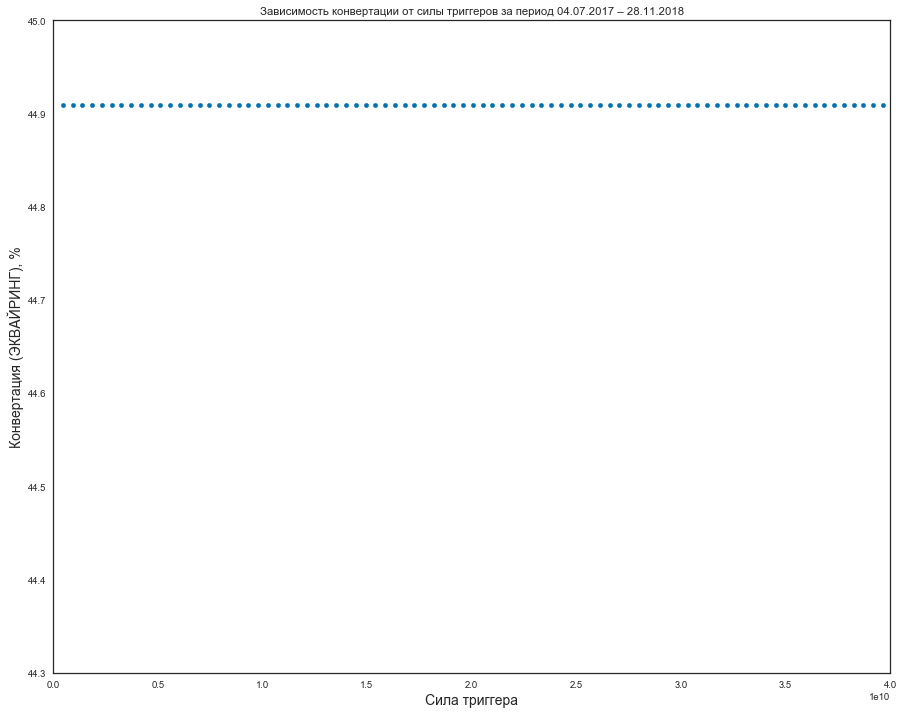

In [129]:
fig,ax=plt.subplots()
ax.scatter( x='thresholding', 
            y='convertation', 
            data=convert_df[convert_df.thresholding!=0], 
            s=20,
            cmap=cmap)
ax.set_xlim(left=0., right=4.e10)
ax.set_ylim(bottom=44.3, top=45)
ax.set_xlabel('Сила триггера', fontsize=14)
ax.set_ylabel('Конвертация ('+ prod_gr_name +'), %', fontsize=14)
plt.title('Зависимость конвертации от силы триггеров за период 04.07.2017 – 28.11.2018')
fig.savefig(get_path('fig', 'conv_vs_trg_force_'+prod_gr_name.lower()+'_.png'), 
            format='png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches=0.1)

### group according to the number of responded triggers

In [145]:
prod_gr_name='ЭКВАЙРИНГ'

In [146]:
new_df=df[(df.prod_gr_atb_seg==prod_gr_name)]

In [147]:
new_df['trg_count'] = (new_df.groupby('task_id')
                                  .task_id
                                  .rank(pct=False,
                                        method='max', 
                                        ascending=True))
new_df['trg_count']=new_df['trg_count'].astype(int)

In [148]:
trg_df=new_df.groupby(['trg_count'])['trg_count'].count().to_frame()
trg_df=trg_df.rename(columns={'trg_count':'number_of_deals'})
trg_df.reset_index(inplace=True)
trg_df['ratio']=trg_df['number_of_deals']/trg_df['number_of_deals'].sum()*100
trg_df

,trg_count,number_of_deals,ratio
0,1,1195,65.767749
1,2,360,19.812878
2,3,210,11.557512
3,4,52,2.861860


In [110]:
rows_sum=trg_df['number_of_deals'].sum()

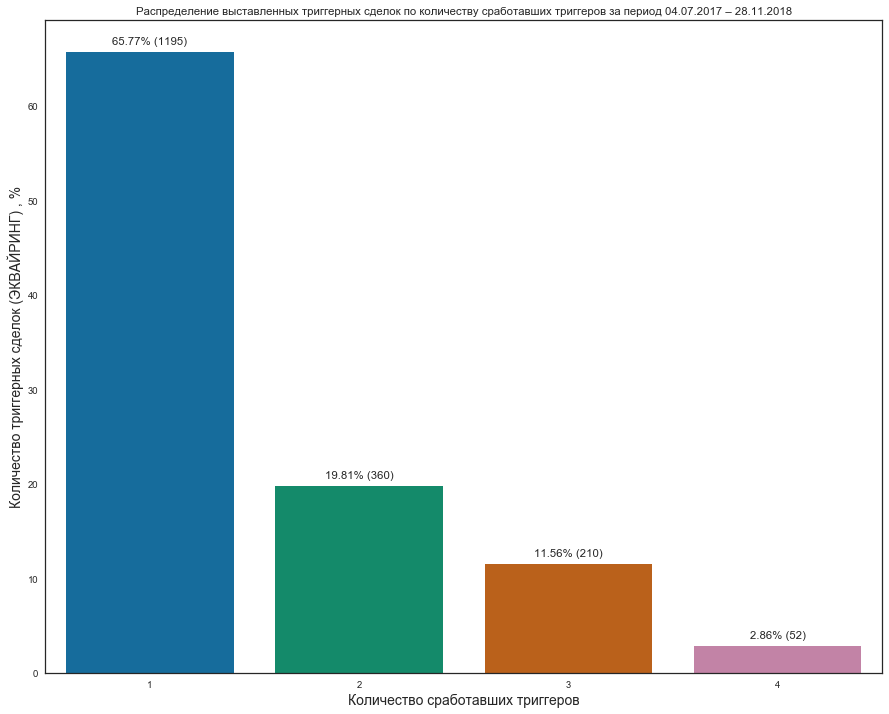

In [111]:
fig=plt.figure()
ax=sns.barplot(x='trg_count', 
                 y='ratio',
                 data=trg_df)
for p in ax.patches:
    ax.annotate('%.2f%% (%.0f)' % (np.round(p.get_height(), decimals=2), np.round(p.get_height()*rows_sum/100, decimals=2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                va='center', xytext=(0, 10), rotation=0, textcoords='offset points')
ax.set_xlabel('Количество сработавших триггеров', fontsize=14)
ax.set_ylabel('Количество триггерных сделок (' + prod_gr_name+') , %', fontsize=14)
plt.legend(loc=9)
plt.title('Распределение выставленных триггерных сделок по количеству сработавших триггеров за период 04.07.2017 – 28.11.2018');
plt.show() 
fig.savefig(get_path('fig', 'dist_deals_vs_trg_'+prod_gr_name+'_.png'), 
            format='png', 
            dpi=400, 
            bbox_inches='tight',
            pad_inches=0.1)

In [149]:
bins=1000
windowing_list=[]
thresholding=np.arange(np.int(trg_df.trg_count.max()))

for i in tqdm(np.arange(len(thresholding))):
    part_df=new_df[( (new_df.amount_complete>0) | (new_df.flag_deal_completed>0) ) & 
                 (new_df.trg_count <= thresholding[i]+1 )]
    windowing_list.append((thresholding[i]+1,len(part_df)/len(new_df)*100.))

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 266.67it/s]


In [150]:
convert_df=pd.DataFrame(data=windowing_list,columns=['thresholding','convertation'])

In [151]:
convert_df

,thresholding,convertation
0,1,29.113924
1,2,37.919648
2,3,43.368189
3,4,44.909191


In [152]:
convert_df.corr()

,thresholding,convertation
thresholding,1.000000,0.955794
convertation,0.955794,1.000000


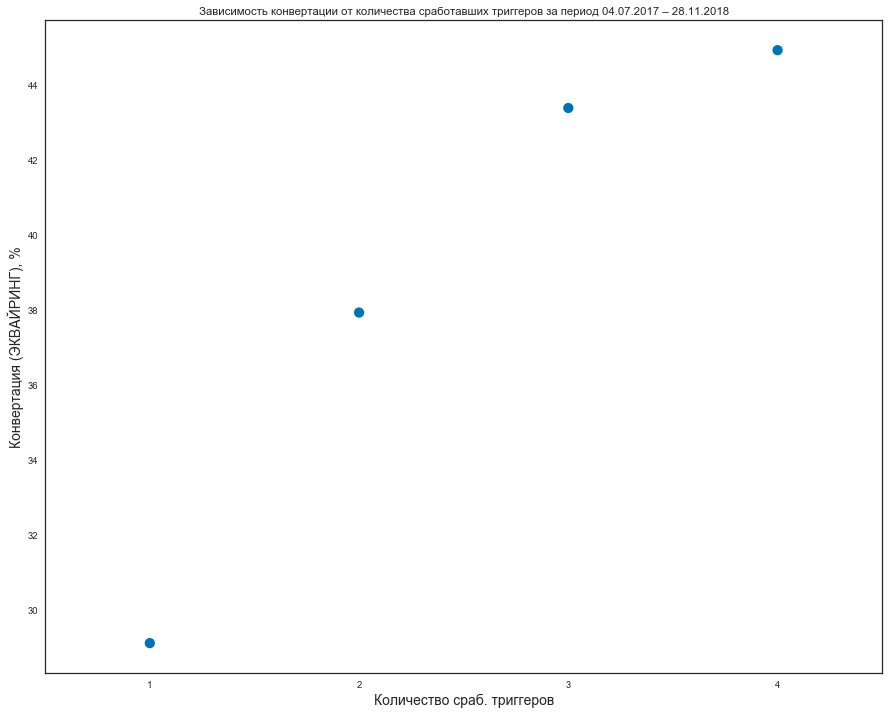

In [116]:
fig,ax=plt.subplots()
ax=sns.pointplot(  x='thresholding',  
                   y='convertation', 
                   data=convert_df[convert_df.thresholding!=0],
                   join=False )
ax.set_xlabel('Количество сраб. триггеров', fontsize=14)
ax.set_ylabel('Конвертация ('+ prod_gr_name +'), %', fontsize=14)
plt.title('Зависимость конвертации от количества сработавших триггеров за период 04.07.2017 – 28.11.2018');
fig.savefig(get_path('fig', 'conv_vs_trg_count_'+prod_gr_name.lower()+'_.png'), 
            format='png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches=0.1)

#ax.set_ylim(bottom=33, top=44)
#ax.set_xlim(left=0, right=4)
#ax.tick_params(axis='x',which='minor',length=0,labelbottom=False)
#ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(plt.NullFormatter())
#ax.xaxis.set_minor_locator(tk.AutoMinorLocator(1))
#plt.setp(ax.get_xticklabels(minor=False),visible=True)

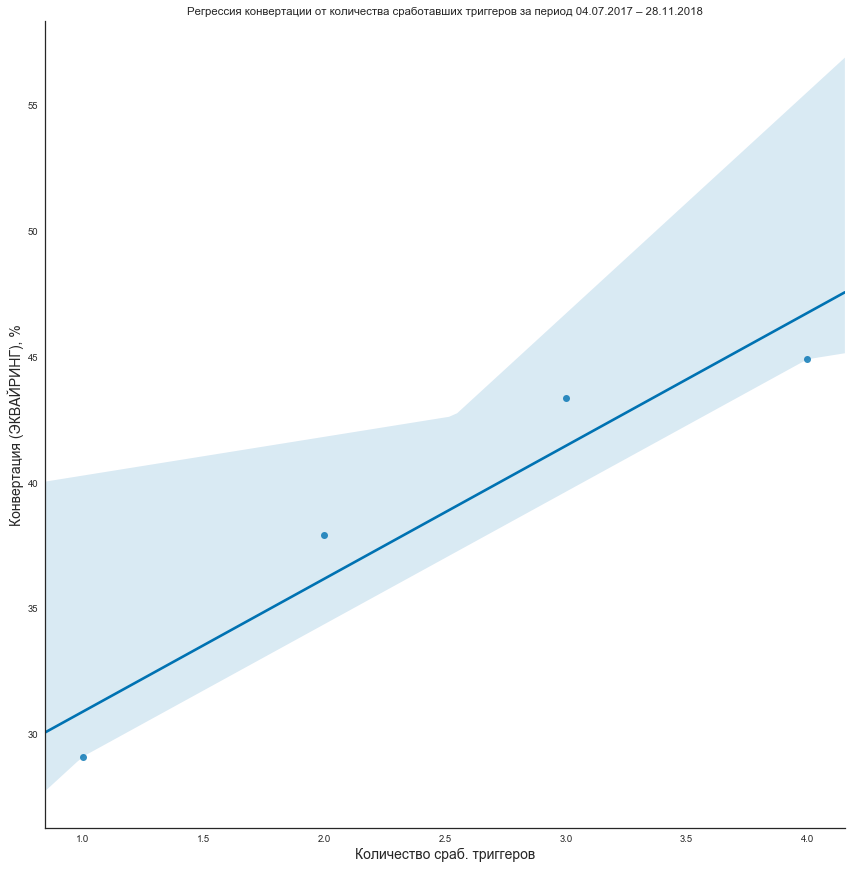

In [154]:
pr=sns.pairplot(x_vars='thresholding',  
                y_vars='convertation', 
                data=convert_df,
                kind='reg',
                size=12.)
#ax.set_ylim(bottom=33, top=44)
#ax.tick_params(axis='x',which='minor',labelbottom=False)
plt.title('Регрессия конвертации от количества сработавших триггеров за период 04.07.2017 – 28.11.2018');
for ax in pr.axes.flat:
    #ax.tick_params(axis='x',which='minor',labelbottom=False)
    #ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
    #ax.xaxis.set_minor_formatter(plt.NullFormatter())
    ax.set_xlabel('Количество сраб. триггеров', fontsize=14)
    ax.set_ylabel('Конвертация ('+ prod_gr_name +'), %', fontsize=14)

    ax.figure.savefig( get_path('fig', 'conv_vs_trg_count_'+prod_gr_name.lower()+'_reg.png'), 
                format='png', 
                dpi=500, 
                bbox_inches='tight',
                pad_inches=0.1)